In [30]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

import re
# function to remove all digits from the abstract
def clean_abstract(text):
    return re.sub(r"\d", "", text)

# Load the data into two dataframes
# Replace "df1" and "df2" with your actual dataframes
data1 = pd.read_csv('final_patent.csv').sample(n=2000)
data1 = data1.dropna()
data1 = data1.reset_index(drop=True)
data1['text'] = data1['patent_title'].astype(str) + ' ' + data1['patent_abstract'].astype(str)
data1['text'] = data1['text'].apply(lambda x: x.lower())
data1['text'] = data1['text'].apply(clean_abstract)
data1['text'] = data1['text'].astype(str)


# data2 = pd.read_csv('abstract_title_text_RD.csv').sample(n=2000)
data2 = pd.read_csv('abstract_title_text_RD.csv').sample(n=2000)
data2 = data2.dropna()
data2 = data2.reset_index(drop=True)
data2['text'] = data2['title'].astype(str) + ' ' + data2['abstract'].astype(str)

data2['text'] = data2['text'].apply(lambda x: x.lower())
data2['text'] = data2['text'].apply(clean_abstract)
data2['text'] = data2['text'].str.rsplit('.', 1).str[0]
# test_data = rd
data2["text"] = data2["text"].astype(str)

cuda


In [31]:
df1 = data1
df2 = data2
model = BertModel.from_pretrained('bert-base-uncased').to(device)

model = model.to(device)

# @jit(target_backend='cuda')
# Assuming you have a column named "text" in both dataframes that contains the text data

# Function to obtain BERT CLS token representation for a given text
def get_bert_cls_embedding(text):
    with torch.no_grad():
        # Truncate or shorten the text if it exceeds the maximum length of BERT
        inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=250, return_tensors='pt', truncation=True, padding = True).to(device)
        outputs = model(**inputs)
        cls_embedding = outputs[0][:, 0, :].detach().cpu().numpy()
    return cls_embedding

# Obtain BERT CLS token representations for each row in dataframe 1
df1['bert_cls'] = data1['text'].apply(get_bert_cls_embedding)
# display(df1)
# Obtain BERT CLS token representations for each row in dataframe 2
df2['bert_cls'] = data2['text'].apply(get_bert_cls_embedding)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Reshape the embeddings to 2D arrays
df1_embeddings = np.vstack(df1['bert_cls'].tolist())
df2_embeddings = np.vstack(df2['bert_cls'].tolist())

# Compute cosine similarity between each pair of embeddings
similarity_scores = cosine_similarity(df1_embeddings, df2_embeddings)


In [33]:
import pandas as pd
import numpy as np
import itertools   
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Get BERT CLS token representations for both dataframes
df1_cls_representations = list(itertools.chain(*df1.bert_cls))
df2_cls_representations = list(itertools.chain(*df2.bert_cls))

# Concatenate the representations and create a combined dataframe
combined_cls_representations = np.vstack((df1_cls_representations, df2_cls_representations))
combined_df = pd.concat([df1, df2], ignore_index=True)

# Perform t-SNE on the combined CLS token representations
tsne = TSNE(n_components=2, random_state=42)  # specify perplexity value
embeddings = tsne.fit_transform(combined_cls_representations)

# PCA
# pca = PCA(n_components=2, random_state=42)
# embeddings = pca.fit_transform(combined_cls_representations)

df = pd.DataFrame(embeddings, columns=['x', 'y'])

df.loc[:len(df1), 'label'] = "Patents"
df.loc[len(df1): , 'label'] = "Research Disclosures"

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


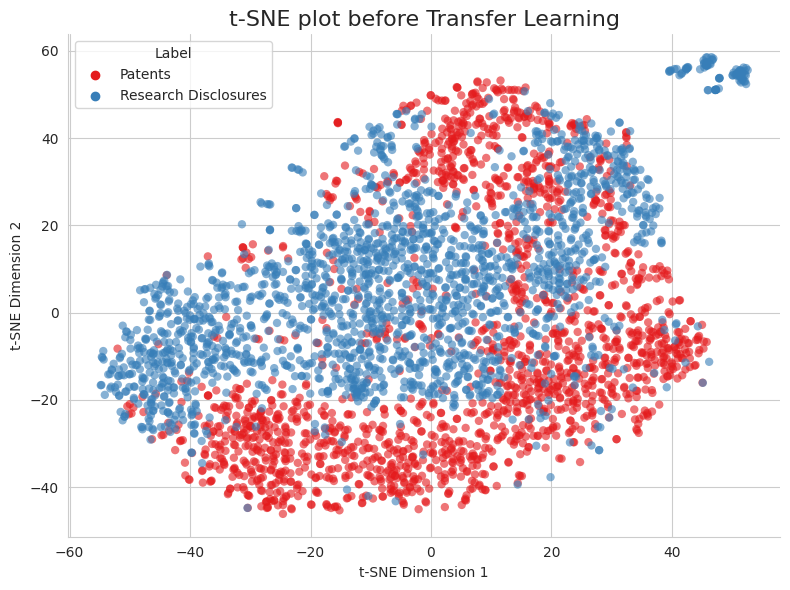

In [34]:
# Set the style of the plot
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

label_palette = sns.color_palette('Set1', n_colors=len(df['label'].unique()))

# Create a scatter plot with colored points based on the label
sns.scatterplot(data=df, x='x', y='y', hue='label', palette=label_palette, alpha=0.6, edgecolor='none')

# # Create the KDE plot with 2D kernel density estimation for each label
# for i, label in enumerate(subset_df['label'].unique()):
#     label_data = subset_df[subset_df['label'] == label]
#     sns.kdeplot(data=label_data, x='x', y='y', levels=5, linewidths=1, color=label_palette[i], alpha=1)

# # Set the x and y axis limits
# plt.xlim(-100, 130)
# plt.ylim(-70, 70)

# Add a legend with proper labels
plt.legend(title='Label')

# Set the title and axes labels
plt.title("t-SNE plot before Transfer Learning", fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# Remove top and right spines
sns.despine()

# Add a colorbar for the scatter plot
# scatter_plot = plt.scatter([], [], c=[], cmap='Set1')
# plt.colorbar(scatter_plot, label='Label')

# Display the plot
plt.tight_layout()
plt.savefig('tsne_before_abs_tit_TL.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig('tsne_before_abs_tit_TL.eps', format='eps', dpi=300, bbox_inches='tight')


plt.show()


In [35]:
#Check for outliers

In [36]:
filtered_df = df[(df['label'] == 'Research Disclosures') & (df['x'] > 40) & (df['y'] > 40)]

In [37]:
# Retrieve the rows from df1 and df2
closest_source_row = combined_df.iloc[1829, :].text

# Print the rows
print("rd")
print(closest_source_row)


rd
composite shroud box  composite shroud box the invention allows for the reduction of the torsional stiffness of closed box composite structures which have been designed to replace a metallic structure. reducing the torsional stiffness of a metallic box via a slot is well known. this type of feature would be undesirable in a composite box given the manufacturing challenges as well as having an exposed composite laminate edge. by replacing fabricated metallic structures (i.e. conventional skin/spar/rib structures) with co-cured composite structures, there is potential for a significant weight saving through the reduced parts count and elimination of fasteners. similarly, through reduced manufacturing man hours, there is a potential recurring cost reduction. for a composite multi-cell box the slot feature being undesirable, the invention allows for the reduced torsional stiffness of an open-section torsion box to be matched in a closed-box structure


In [38]:
#Tsne after transfer learning

In [39]:
# !pip install transformers
import transformers
from typing import List, Optional, Tuple, Union
class BertClassificationMetadata(transformers.BertPreTrainedModel):
    def __init__(self, config, num_year_ids, metadata_embedding_size, hidden_layer_size, dropout_fine_tune):
        super().__init__(config)
        self.bert = transformers.BertModel(config)
        self.num_labels = config.num_labels
        self.config = config

        self.dropout = nn.Dropout(dropout_fine_tune)
        self.embedding_year = nn.Embedding(num_year_ids, metadata_embedding_size) #32, 128       
        self.layer_normalizer = nn.LayerNorm(768 + metadata_embedding_size) # 896
        self.fc1_hidden = nn.Linear(768 + metadata_embedding_size, hidden_layer_size)#896 , 2048
        self.fc2_hidden = nn.Linear(hidden_layer_size, hidden_layer_size)#2048 , 2048
        self.fc_classifier = nn.Linear(hidden_layer_size, config.num_labels)

        # Initialize weights and apply final processing

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        year_ids: Optional[torch.Tensor] = None,
    ) -> Union[Tuple[torch.Tensor], transformers.modeling_outputs.SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        year_embedding = self.embedding_year(year_ids)

        pooled_bert_output = outputs[1]
        
        # print(pooled_bert_output.size(), year_embedding.size())
        
        # concat
        input_classification_head = torch.cat((pooled_bert_output, year_embedding), dim=1)#32, 1024

        # fc1
        input_fc1_hidden = self.dropout(self.layer_normalizer(input_classification_head))#32, 1024
        output_fc1_hidden = self.fc1_hidden(input_fc1_hidden)# 32, 768

        # fc2
        input_fc2_hidden = torch.relu(self.dropout(output_fc1_hidden))
        output_fc2_hidden = self.fc2_hidden(input_fc2_hidden) #32, 768

        # logit classifier
        input_fc_classifier = torch.relu(self.dropout(output_fc2_hidden))
        logits = self.fc_classifier(input_fc_classifier)

        # loss
        # loss_fct = nn.CrossEntropyLoss()
        # loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # loss
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        else:
            loss = None
            
        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = torch.load(('bert-base-uncased-with-metadata-2hidden_layers.pt'), map_location=torch.device(device))
model = model.to(device)


In [41]:
df1 = data1
df2 = data2

df1['year'] = pd.to_datetime(df1['patent_date']).dt.year
year_dict = {k: k-df1['year'].min() for k in df1['year'].unique()}
df1['year_ids'] = df1['year'].replace(year_dict)

df2['year'] = pd.to_datetime(df2['date']).dt.year
year_dict = {k: k-df2['year'].min() for k in df2['year'].unique()}
df2['year_ids'] = df2['year'].replace(year_dict)

In [42]:
feature_text_source, feature_year_source = df1['text'].to_list(), df1['year_ids'].to_list()
feature_text_target, feature_year_target = df2['text'].to_list(), df2['year_ids'].to_list()

In [43]:
from tqdm import tqdm
# median_token_length = int(median_token_length)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def fast_encode(texts, tokenizer, chunk_size=512, maxlen=250):
    input_ids = []
    attention_mask = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i + chunk_size]
        encs = tokenizer.batch_encode_plus(
            text_chunk,
            max_length=maxlen,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )        
        input_ids.append(encs['input_ids'])
        attention_mask.append(encs['attention_mask'])

    return {
        'input_ids': torch.cat(input_ids, dim=0).squeeze(),
        'attention_mask': torch.cat(attention_mask, dim=0).squeeze()
    }

In [44]:
# Setup the pre-treained BERT Tokenizer
bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
feature_text_source = fast_encode(feature_text_source, tokenizer)
feature_text_target = fast_encode(feature_text_target, tokenizer)

# Apply the tokenizer to the datasets
# feature_text_target= bert_tokenizer(feature_text_target, padding='max_length', max_length = median_token_length, truncation =True, return_tensors='pt')



# data loader for transformers
class AttributeDataset(torch.utils.data.Dataset):
  def __init__(self, tokenized_text: torch.Tensor, year_ids):
    self.tokenized_features = tokenized_text
    self.year_ids = torch.tensor(year_ids)
  
  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.tokenized_features.items()}
    item['year_ids'] = self.year_ids[idx]
    return item

  def __len__(self):
    return df1.shape[0]

source_torch = AttributeDataset(feature_text_source, feature_year_source)
source_dataloader = torch.utils.data.DataLoader(source_torch, batch_size=30)

# data loader for transformers
class AttributeDataset(torch.utils.data.Dataset):
  def __init__(self, tokenized_text: torch.Tensor, year_ids):
    self.tokenized_features = tokenized_text
    self.year_ids = torch.tensor(year_ids)
  
  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.tokenized_features.items()}
    item['year_ids'] = self.year_ids[idx]
    return item

  def __len__(self):
    return df2.shape[0]

target_torch = AttributeDataset(feature_text_target, feature_year_target)
target_dataloader = torch.utils.data.DataLoader(target_torch, batch_size=30)


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


In [45]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define a function to extract hidden states from the model
def get_hidden_states(model, dataloader):
    hidden_states = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            hidden_states.extend(outputs.hidden_states[-1].cpu().numpy())  # Extract the last hidden state
    
    return hidden_states

# Extract hidden states for source data
source_hidden_states = get_hidden_states(model, source_dataloader)

# Extract hidden states for target data
target_hidden_states = get_hidden_states(model, target_dataloader)

# Concatenate the hidden states
all_hidden_states = np.concatenate([source_hidden_states, target_hidden_states], axis=0)

# Flatten the hidden states
flattened_hidden_states = all_hidden_states.reshape(all_hidden_states.shape[0], -1)

# Apply t-SNE on the flattened hidden states
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(flattened_hidden_states)

# Separate the t-SNE embeddings for source and target data
source_tsne_embeddings = tsne_embeddings[:len(source_hidden_states)]
target_tsne_embeddings = tsne_embeddings[len(source_hidden_states):]


In [46]:
#Get most similar research disclosure and patent

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

# Reshape the embeddings to 2D arrays
df1_embeddings = np.vstack(df1['bert_cls'].tolist())
df2_embeddings = np.vstack(df2['bert_cls'].tolist())

# Compute cosine similarity between each pair of embeddings
similarity_scores = cosine_similarity(df1_embeddings, df2_embeddings)

In [48]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have already defined source_hidden_states and target_hidden_states as lists

# Convert lists to NumPy arrays
source_hidden_states = np.array(source_hidden_states)
target_hidden_states = np.array(target_hidden_states)

# Reshape the arrays to 2D
source_hidden_states_2d = source_hidden_states.reshape(source_hidden_states.shape[0], -1)

# Reshape target_hidden_states to 2D
target_hidden_states_2d = target_hidden_states.reshape(target_hidden_states.shape[0], -1)

# Compute cosine similarity between each pair of embeddings
similarity_scores_1 = cosine_similarity(source_hidden_states_2d, target_hidden_states_2d)


In [49]:
difference = similarity_scores - similarity_scores_1
max_difference = np.max(difference)

if max_difference > 0:
    max_difference_index = np.unravel_index(np.argmax(difference), difference.shape)
    print(f"The pair with the highest difference is ({max_difference_index[0]}, {max_difference_index[1]})")
    print(f"Difference: {max_difference}")
else:
    print("No difference found.")


The pair with the highest difference is (948, 1792)
Difference: 0.9407726526260376


In [50]:
row_indices = [(135, 1639)]  # Indices of the rows to retrieve

# Flatten the row_indices list
flattened_indices = [idx for sublist in row_indices for idx in sublist]

# Retrieve the selected rows from df
selected_rows = df.iloc[flattened_indices][['label']]

# Print the selected rows
print(selected_rows)


        label
135   Patents
1639  Patents


In [51]:
#Plot of t-sne after transfer learning

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


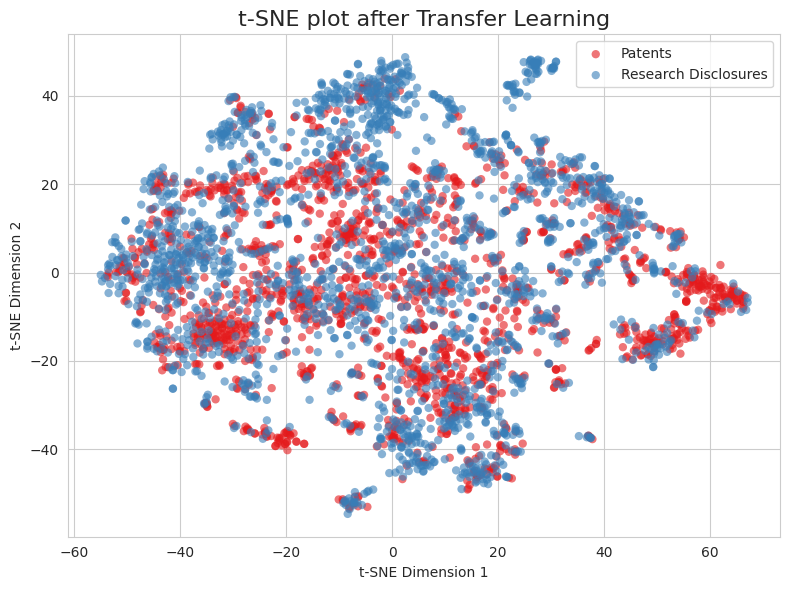

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
plt.figure(figsize=(8, 6))

# Set the Seaborn color palette
sns.set_palette('Set1')

# Create a scatter plot with colored points for source and target data
plt.scatter(source_tsne_embeddings[:, 0], source_tsne_embeddings[:, 1], label='Patents', color=sns.color_palette()[0], alpha=0.6, edgecolor='none')
plt.scatter(target_tsne_embeddings[:, 0], target_tsne_embeddings[:, 1], label='Research Disclosures', color=sns.color_palette()[1], alpha=0.6, edgecolor='none')

# Add a legend with proper labels
plt.legend()

# Set the title and axes labels
plt.title("t-SNE plot after Transfer Learning", fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Show the plot
plt.tight_layout()

plt.savefig('tsne_after_TL.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig('tsne_after_TL.eps', format='eps', dpi=300, bbox_inches='tight')

# plt.savefig('tsne_250_tokens_after_TL.eps', format='eps')
# plt.savefig('tsne_250_tokens_after_TL.png', format='png')

plt.show()


In [53]:
#Plot of closest Research disclosure and Patent data point 

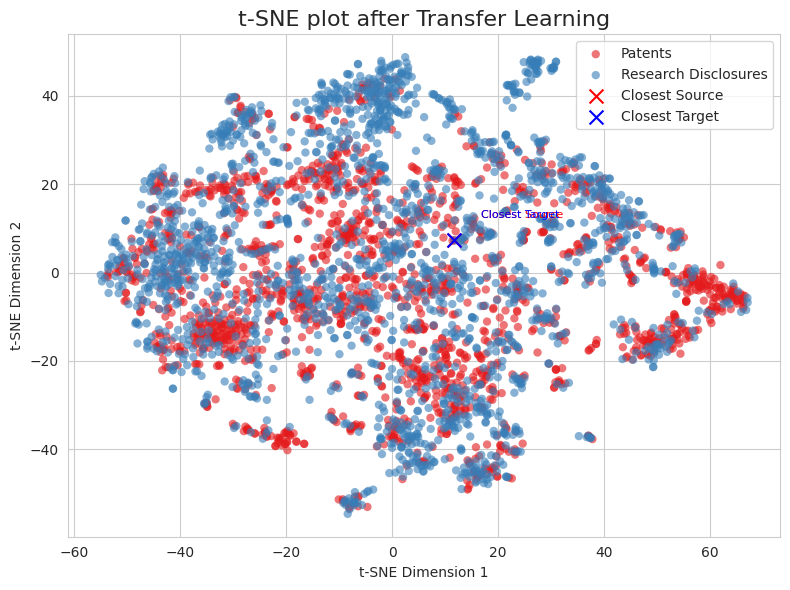

Closest Source Index: 405
Closest Target Index: 1179


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Set the style of the plot
plt.figure(figsize=(8, 6))

# Set the Seaborn color palette
sns.set_palette('Set1')

# Create a scatter plot with colored points for source and target data
plt.scatter(source_tsne_embeddings[:, 0], source_tsne_embeddings[:, 1], label='Patents', color=sns.color_palette()[0], alpha=0.6, edgecolor='none')
plt.scatter(target_tsne_embeddings[:, 0], target_tsne_embeddings[:, 1], label='Research Disclosures', color=sns.color_palette()[1], alpha=0.6, edgecolor='none')

# Add a legend with proper labels
plt.legend()

# Set the title and axes labels
plt.title("t-SNE plot after Transfer Learning", fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Calculate pairwise distances between all source and target points
distances = distance.cdist(source_tsne_embeddings, target_tsne_embeddings)

# Find the indices of the closest pair of points
closest_indices = np.unravel_index(np.argmin(distances), distances.shape)

# Get the closest source and target points
closest_source_point = source_tsne_embeddings[closest_indices[0]]
closest_target_point = target_tsne_embeddings[closest_indices[1]]

# Plot the closest source and target points
plt.scatter(closest_source_point[0], closest_source_point[1], color='red', marker='x', s=100, label='Closest Source')
plt.scatter(closest_target_point[0], closest_target_point[1], color='blue', marker='x', s=100, label='Closest Target')

# Annotate the closest points
plt.annotate('Closest Source', xy=(closest_source_point[0], closest_source_point[1]), xytext=(closest_source_point[0] + 5, closest_source_point[1] + 5), color='red', fontsize=8)
plt.annotate('Closest Target', xy=(closest_target_point[0], closest_target_point[1]), xytext=(closest_target_point[0] + 5, closest_target_point[1] + 5), color='blue', fontsize=8)

# Add a legend with proper labels including the new points
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Print the indices of the closest points
closest_source_index = closest_indices[0]
closest_target_index = closest_indices[1]
print("Closest Source Index:", closest_source_index)
print("Closest Target Index:", closest_target_index)


In [55]:
# Retrieve the rows from df1 and df2
closest_source_row = df1.iloc[closest_source_index, :]
closest_target_row = df2.iloc[closest_target_index, :]

# Print the rows
print("Closest Source Row:")
print(closest_source_row)

print("\nClosest Target Row:")
print(closest_target_row)


Closest Source Row:
Unnamed: 0                                                   1679923
patent_id                                                    4245983
patent_date                                               1981-01-20
patent_title       Screw conveyor for feeding lime sludge or ceme...
patent_abstract     The invention relates to a feed conveyor for ...
cpc_code                                                         F27
text               screw conveyor for feeding lime sludge or ceme...
bert_cls           [[-0.51994485, 0.14106219, 0.18153188, -0.1590...
year                                                            1981
year_ids                                                           5
Name: 405, dtype: object

Closest Target Row:
Unnamed: 0                                                 8555
rdid                                                     229039
title         Method and apparatus for removal of SO2 from f...
abstract      22939 Method and apparatus for removal